<a href="https://colab.research.google.com/github/ISRAEL-MP/Practica0_Comentario_codigo_-limpio/blob/main/examen_final1_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clasificador de imágenes

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization, Input
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, ModelCheckpoint
from keras.utils import np_utils
import os
import numpy as np
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input, decode_predictions
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import ImageDataGenerator 
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

# Configuración de parámetros

In [4]:
width_shape = 250
height_shape = 250
num_classes = 3
epochs = 80
batch_size = 32 

# Path de dataset

In [5]:
train_data_dir = '/content/drive/MyDrive/minerales1/entrenamiento'  
validation_data_dir = '/content/drive/MyDrive/minerales1/Prueba'

# Generador de imágenes (entrenamiento y validación)

In [6]:
train_datagen = ImageDataGenerator(  
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=False,
    preprocessing_function=preprocess_input)

valid_datagen = ImageDataGenerator(    
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=False,
    preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(  
    train_data_dir,
    target_size=(width_shape, height_shape),
    batch_size=batch_size,
    #save_to_dir='',
    class_mode='categorical')

validation_generator = valid_datagen.flow_from_directory(  
    validation_data_dir,
    target_size=(width_shape, height_shape),
    batch_size=batch_size,
    #save_to_dir='',
    class_mode='categorical')




Found 125 images belonging to 3 classes.
Found 125 images belonging to 3 classes.


# Numero de imagenes de entrenamiento y validación

In [7]:
nb_train_samples = 75
nb_validation_samples = 50

# Creación y entrenamiento de modelo CNN

In [9]:
#Creación de modelo 
model = Sequential()

inputShape = (height_shape, width_shape, 3)
model.add(Conv2D(32,(3,3), input_shape=inputShape))
model.add(Conv2D(32,(3,3)))
model.add(MaxPool2D())
          
model.add(Conv2D(64,(3,3)))
model.add(Conv2D(64,(3,3)))
model.add(Conv2D(64,(3,3)))
model.add(MaxPool2D())

model.add(Flatten())
model.add(Dense(64,activation='relu'))
model.add(Dense(32,activation='relu'))
model.add(Dense(num_classes,activation='softmax', name='output'))

model.summary()

model.compile(loss='categorical_crossentropy',optimizer='adadelta',metrics=['accuracy'])

model_history = model.fit_generator(  
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    steps_per_epoch=nb_train_samples//batch_size,
    validation_steps=nb_validation_samples//batch_size)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 248, 248, 32)      896       
                                                                 
 conv2d_6 (Conv2D)           (None, 246, 246, 32)      9248      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 123, 123, 32)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 121, 121, 64)      18496     
                                                                 
 conv2d_8 (Conv2D)           (None, 119, 119, 64)      36928     
                                                                 
 conv2d_9 (Conv2D)           (None, 117, 117, 64)      36928     
                                                      

<ipython-input-9-1d6c5b1e25e0>:23: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_history = model.fit_generator(


Epoch 1/80
2/2 [==============================] - 19s 14s/step - loss: 24.0513 - accuracy: 0.3750 - val_loss: 19.6745 - val_accuracy: 0.4062
Epoch 2/80
2/2 [==============================] - 8s 7s/step - loss: 19.8831 - accuracy: 0.2969 - val_loss: 12.2226 - val_accuracy: 0.3438
Epoch 3/80
2/2 [==============================] - 6s 5s/step - loss: 11.3670 - accuracy: 0.4531 - val_loss: 7.3438 - val_accuracy: 0.5312
Epoch 4/80
2/2 [==============================] - 8s 7s/step - loss: 13.2232 - accuracy: 0.4426 - val_loss: 9.8381 - val_accuracy: 0.4062
Epoch 5/80
2/2 [==============================] - 3s 2s/step - loss: 8.2124 - accuracy: 0.5246 - val_loss: 8.5717 - val_accuracy: 0.5000
Epoch 6/80
2/2 [==============================] - 4s 3s/step - loss: 9.0493 - accuracy: 0.4754 - val_loss: 6.4297 - val_accuracy: 0.5938
Epoch 7/80
2/2 [==============================] - 2s 2s/step - loss: 8.2780 - accuracy: 0.4754 - val_loss: 12.4284 - val_accuracy: 0.5625
Epoch 8/80
2/2 [================

# Transfer Learning modelo VGG16 - solo agregamos capa Dense

In [11]:
image_input = Input(shape=(width_shape, height_shape, 3))

model = VGG16(input_tensor=image_input, include_top=True,weights='imagenet')

last_layer = model.get_layer('fc2').output
out = Dense(num_classes, activation='softmax', name='output')(last_layer)
custom_model = Model(image_input, out)

for layer in custom_model.layers[:-1]:
	layer.trainable = False
    

custom_model.compile(loss='categorical_crossentropy',optimizer='adadelta',metrics=['accuracy'])

custom_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 250, 250, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 250, 250, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 250, 250, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 125, 125, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 125, 125, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 125, 125, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 62, 62, 128)       0   

In [12]:
model_history = custom_model.fit_generator(  
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    steps_per_epoch=nb_train_samples//batch_size,
    validation_steps=nb_validation_samples//batch_size)

<ipython-input-12-c43507f6a308>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_history = custom_model.fit_generator(


Epoch 1/80
2/2 [==============================] - 14s 7s/step - loss: 1.9593 - accuracy: 0.1967 - val_loss: 1.7605 - val_accuracy: 0.2812
Epoch 2/80
2/2 [==============================] - 2s 2s/step - loss: 1.5639 - accuracy: 0.3115 - val_loss: 1.7727 - val_accuracy: 0.1875
Epoch 3/80
2/2 [==============================] - 3s 2s/step - loss: 1.6333 - accuracy: 0.2188 - val_loss: 1.6572 - val_accuracy: 0.3125
Epoch 4/80
2/2 [==============================] - 3s 2s/step - loss: 2.1219 - accuracy: 0.1639 - val_loss: 1.5027 - val_accuracy: 0.2500
Epoch 5/80
2/2 [==============================] - 2s 2s/step - loss: 1.6147 - accuracy: 0.2344 - val_loss: 1.6795 - val_accuracy: 0.2812
Epoch 6/80
2/2 [==============================] - 2s 2s/step - loss: 1.8658 - accuracy: 0.1803 - val_loss: 2.1114 - val_accuracy: 0.1562
Epoch 7/80
2/2 [==============================] - 2s 2s/step - loss: 1.7150 - accuracy: 0.3115 - val_loss: 1.4645 - val_accuracy: 0.4062
Epoch 8/80
2/2 [========================

# Transfer Learning modelo VGG16 - fine tune

In [13]:
image_input = Input(shape=(width_shape, height_shape, 3))

model2 = VGG16(input_tensor=image_input, include_top=True,weights='imagenet')

model2.summary()

last_layer = model2.get_layer('block5_pool').output
x= Flatten(name='flatten')(last_layer)
x = Dense(128, activation='relu', name='fc1')(x)
x = Dense(128, activation='relu', name='fc2')(x)
out = Dense(num_classes, activation='softmax', name='output')(x)
custom_model = Model(image_input, out)
custom_model.summary()

# freeze all the layers except the dense layers
for layer in custom_model.layers[:-3]:
	layer.trainable = False

custom_model.summary()

custom_model.compile(loss='categorical_crossentropy',optimizer='adadelta',metrics=['accuracy'])

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 250, 250, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 250, 250, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 250, 250, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 125, 125, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 125, 125, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 125, 125, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 62, 62, 128)       0     

In [14]:
model_history = custom_model.fit_generator(  
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    steps_per_epoch=nb_train_samples//batch_size,
    validation_steps=nb_validation_samples//batch_size)

<ipython-input-14-c43507f6a308>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_history = custom_model.fit_generator(


Epoch 1/80
2/2 [==============================] - 4s 2s/step - loss: 6.7552 - accuracy: 0.3594 - val_loss: 5.5538 - val_accuracy: 0.3750
Epoch 2/80
2/2 [==============================] - 4s 3s/step - loss: 6.3468 - accuracy: 0.3906 - val_loss: 6.4639 - val_accuracy: 0.1875
Epoch 3/80
2/2 [==============================] - 2s 2s/step - loss: 4.8844 - accuracy: 0.4754 - val_loss: 4.6350 - val_accuracy: 0.5312
Epoch 4/80
2/2 [==============================] - 2s 2s/step - loss: 4.3096 - accuracy: 0.4844 - val_loss: 3.8727 - val_accuracy: 0.5312
Epoch 5/80
2/2 [==============================] - 2s 2s/step - loss: 5.5025 - accuracy: 0.4375 - val_loss: 4.9502 - val_accuracy: 0.4062
Epoch 6/80
2/2 [==============================] - 3s 2s/step - loss: 4.4193 - accuracy: 0.3438 - val_loss: 3.6743 - val_accuracy: 0.4375
Epoch 7/80
2/2 [==============================] - 4s 3s/step - loss: 4.2555 - accuracy: 0.3934 - val_loss: 5.5415 - val_accuracy: 0.3438
Epoch 8/80
2/2 [=========================

# Transfer Learning modelo Resnet50 - fine tune

In [15]:
from keras.applications.resnet import ResNet50

image_input = Input(shape=(width_shape, height_shape, 3))

m_Resnet50 = ResNet50(input_tensor=image_input, include_top=False,weights='imagenet')

m_Resnet50.summary()

last_layer = m_Resnet50.layers[-1].output

x= Flatten(name='flatten')(last_layer)
x = Dense(128, activation='relu', name='fc1')(x)
x=Dropout(0.3)(x)
x = Dense(128, activation='relu', name='fc2')(x)
x=Dropout(0.3)(x)
out = Dense(num_classes, activation='softmax', name='output')(x)
custom_model = Model(image_input, out)
custom_model.summary()

# freeze all the layers except the dense layers
for layer in custom_model.layers[:-6]:
    layer.trainable = False

    
custom_model.summary()

custom_model.compile(loss='categorical_crossentropy',optimizer='adadelta',metrics=['accuracy'])

94765736/94765736 [==============================] - 1s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 250, 250, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 256, 256, 3)  0           ['input_4[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 125, 125, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                          

In [16]:
model_history = custom_model.fit_generator(  
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    steps_per_epoch=nb_train_samples//batch_size,
    validation_steps=nb_validation_samples//batch_size)

<ipython-input-16-c43507f6a308>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_history = custom_model.fit_generator(


Epoch 1/80
2/2 [==============================] - 12s 4s/step - loss: 2.0789 - accuracy: 0.2787 - val_loss: 1.3698 - val_accuracy: 0.3750
Epoch 2/80
2/2 [==============================] - 2s 2s/step - loss: 1.9446 - accuracy: 0.2500 - val_loss: 1.3304 - val_accuracy: 0.3438
Epoch 3/80
2/2 [==============================] - 3s 2s/step - loss: 1.6354 - accuracy: 0.4062 - val_loss: 1.1983 - val_accuracy: 0.3125
Epoch 4/80
2/2 [==============================] - 3s 2s/step - loss: 1.9162 - accuracy: 0.4062 - val_loss: 1.2741 - val_accuracy: 0.3438
Epoch 5/80
2/2 [==============================] - 2s 2s/step - loss: 1.6898 - accuracy: 0.3607 - val_loss: 1.4368 - val_accuracy: 0.3438
Epoch 6/80
2/2 [==============================] - 2s 2s/step - loss: 1.5407 - accuracy: 0.3438 - val_loss: 0.9166 - val_accuracy: 0.6562
Epoch 7/80
2/2 [==============================] - 2s 2s/step - loss: 1.7093 - accuracy: 0.3115 - val_loss: 1.0993 - val_accuracy: 0.5000
Epoch 8/80
2/2 [========================

# Transfer Learning modelo VGG19 - fine tune

In [17]:
from keras.applications.vgg19 import VGG19


image_input = Input(shape=(width_shape, height_shape, 3))

m_VGG19 = VGG19(input_tensor=image_input, include_top=False,weights='imagenet')

m_VGG19.summary()

last_layer = m_VGG19.layers[-1].output
x= Flatten(name='flatten')(last_layer)
x = Dense(128, activation='relu', name='fc1')(x)
x=Dropout(0.3)(x)
x = Dense(128, activation='relu', name='fc2')(x)
x=Dropout(0.3)(x)
out = Dense(num_classes, activation='softmax', name='output')(x)
custom_model = Model(image_input, out)
custom_model.summary()

# freeze all the layers except the dense layers
for layer in custom_model.layers[:-6]:
	layer.trainable = False

custom_model.summary()

custom_model.compile(loss='categorical_crossentropy',optimizer='adadelta',metrics=['accuracy'])

80134624/80134624 [==============================] - 0s 0us/step
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 250, 250, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 250, 250, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 250, 250, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 125, 125, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 125, 125, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 125, 125, 128)     147584    
                                                              

In [18]:
model_history = custom_model.fit_generator(  
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    steps_per_epoch=nb_train_samples//batch_size,
    validation_steps=nb_validation_samples//batch_size)

<ipython-input-18-c43507f6a308>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_history = custom_model.fit_generator(


Epoch 1/80
2/2 [==============================] - 4s 2s/step - loss: 13.2079 - accuracy: 0.3750 - val_loss: 8.7828 - val_accuracy: 0.4688
Epoch 2/80
2/2 [==============================] - 4s 3s/step - loss: 11.3061 - accuracy: 0.3750 - val_loss: 7.6344 - val_accuracy: 0.5000
Epoch 3/80
2/2 [==============================] - 3s 2s/step - loss: 11.5165 - accuracy: 0.2812 - val_loss: 7.1565 - val_accuracy: 0.3750
Epoch 4/80
2/2 [==============================] - 2s 2s/step - loss: 9.0961 - accuracy: 0.4098 - val_loss: 8.1296 - val_accuracy: 0.2812
Epoch 5/80
2/2 [==============================] - 2s 2s/step - loss: 10.4230 - accuracy: 0.3443 - val_loss: 6.0558 - val_accuracy: 0.3750
Epoch 6/80
2/2 [==============================] - 4s 3s/step - loss: 9.7050 - accuracy: 0.3438 - val_loss: 7.5968 - val_accuracy: 0.4688
Epoch 7/80
2/2 [==============================] - 2s 2s/step - loss: 8.8923 - accuracy: 0.3594 - val_loss: 6.2120 - val_accuracy: 0.4062
Epoch 8/80
2/2 [=====================

# Modelo Mobilenet - Entrenamiento de toda la red


In [19]:
from keras.applications.mobilenet import MobileNet


image_input = Input(shape=(width_shape, height_shape, 3))

m_MobileNet = MobileNet(input_tensor=image_input, include_top=False,weights='imagenet')


m_MobileNet.summary()

last_layer = m_MobileNet.layers[-1].output
x= Flatten(name='flatten')(last_layer)
x = Dense(128, activation='relu', name='fc1')(x)
x=Dropout(0.3)(x)
x = Dense(128, activation='relu', name='fc2')(x)
x=Dropout(0.3)(x)
out = Dense(num_classes, activation='softmax', name='output')(x)
custom_model = Model(image_input, out)
custom_model.summary()




custom_model.compile(loss='categorical_crossentropy',optimizer='adadelta',metrics=['accuracy'])

17225924/17225924 [==============================] - 0s 0us/step
Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 250, 250, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 125, 125, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 125, 125, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 125, 125, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 125, 125, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 125, 125, 32

In [20]:
model_history = custom_model.fit_generator(  
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    steps_per_epoch=nb_train_samples//batch_size,
    validation_steps=nb_validation_samples//batch_size)

<ipython-input-20-c43507f6a308>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_history = custom_model.fit_generator(


Epoch 1/80
2/2 [==============================] - 19s 3s/step - loss: 2.1241 - accuracy: 0.3906 - val_loss: 1.2528 - val_accuracy: 0.4688
Epoch 2/80
2/2 [==============================] - 4s 3s/step - loss: 1.9233 - accuracy: 0.4262 - val_loss: 1.9721 - val_accuracy: 0.3125
Epoch 3/80
2/2 [==============================] - 3s 2s/step - loss: 2.1878 - accuracy: 0.2969 - val_loss: 1.2171 - val_accuracy: 0.4375
Epoch 4/80
2/2 [==============================] - 2s 2s/step - loss: 1.5960 - accuracy: 0.4426 - val_loss: 1.4110 - val_accuracy: 0.4062
Epoch 5/80
2/2 [==============================] - 2s 2s/step - loss: 1.6938 - accuracy: 0.4262 - val_loss: 1.6018 - val_accuracy: 0.3438
Epoch 6/80
2/2 [==============================] - 2s 2s/step - loss: 1.6332 - accuracy: 0.3770 - val_loss: 1.4078 - val_accuracy: 0.3125
Epoch 7/80
2/2 [==============================] - 4s 3s/step - loss: 2.1031 - accuracy: 0.3750 - val_loss: 1.6716 - val_accuracy: 0.3125
Epoch 8/80
2/2 [========================

# Grabar modelo en disco

In [21]:
custom_model.save("model_Mobilenet.h5")


# Gráficas de entrenamiento y validación (accuracy - loss)

In [22]:

def plotTraining(hist, epochs, typeData):
    
    if typeData=="loss":
        plt.figure(1,figsize=(10,5))
        yc=hist.history['loss']
        xc=range(epochs)
        plt.ylabel('Loss', fontsize=24)
        plt.plot(xc,yc,'-r',label='Loss Training')
    if typeData=="accuracy":
        plt.figure(2,figsize=(10,5))
        yc=hist.history['accuracy']
        for i in range(0, len(yc)):
            yc[i]=100*yc[i]
        xc=range(epochs)
        plt.ylabel('Accuracy (%)', fontsize=24)
        plt.plot(xc,yc,'-r',label='Accuracy Training')
    if typeData=="val_loss":
        plt.figure(1,figsize=(10,5))
        yc=hist.history['val_loss']
        xc=range(epochs)
        plt.ylabel('Loss', fontsize=24)
        plt.plot(xc,yc,'--b',label='Loss Validate')
    if typeData=="val_accuracy":
        plt.figure(2,figsize=(10,5))
        yc=hist.history['val_accuracy']
        for i in range(0, len(yc)):
            yc[i]=100*yc[i]
        xc=range(epochs)
        plt.ylabel('Accuracy (%)', fontsize=24)
        plt.plot(xc,yc,'--b',label='Training Validate')
        

    plt.rc('xtick',labelsize=24)
    plt.rc('ytick',labelsize=24)
    plt.rc('legend', fontsize=18) 
    plt.legend()
    plt.xlabel('Number of Epochs',fontsize=24)
    plt.grid(True)

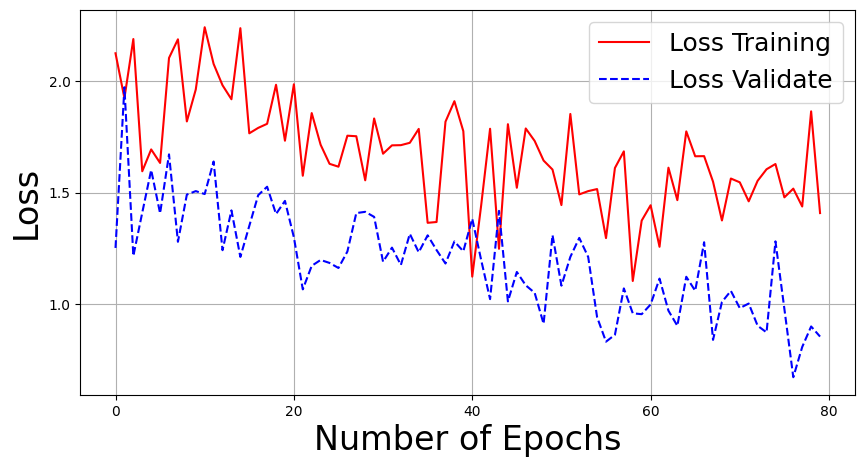

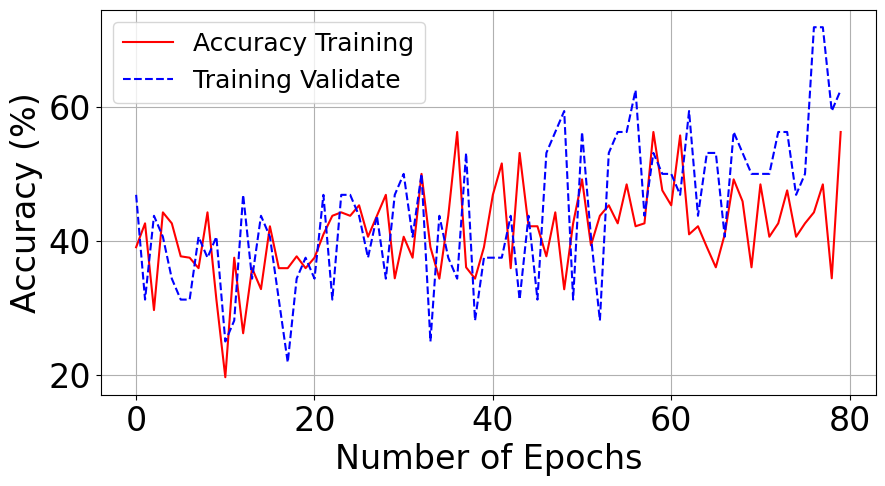

In [23]:
plotTraining(model_history,epochs,"loss")
plotTraining(model_history,epochs,"accuracy")
plotTraining(model_history,epochs,"val_loss")
plotTraining(model_history,epochs,"val_accuracy")

# Predicción usando el modelo entrenado

1/1 [==============================] - 1s 950ms/step
ZINC


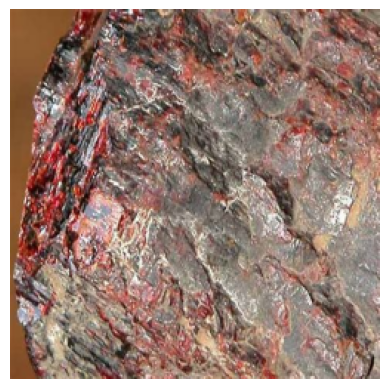

In [24]:
from keras.applications.imagenet_utils import preprocess_input, decode_predictions
from keras.models import load_model

names = ['COBRE','ORO','ZINC']

modelt = load_model("/content/model_Mobilenet.h5")
#modelt = custom_model

imaget_path = "/content/drive/MyDrive/minerales/entrenamiento/zinc/image7.png"
imaget=cv2.resize(cv2.imread(imaget_path), (width_shape, height_shape), interpolation = cv2.INTER_AREA)
xt = np.asarray(imaget)
xt=preprocess_input(xt)
xt = np.expand_dims(xt,axis=0)
preds = modelt.predict(xt)

print(names[np.argmax(preds)])
plt.imshow(cv2.cvtColor(np.asarray(imaget),cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

# Matriz de confusión y métricas de desempeño

Found 15 images belonging to 3 classes.


<ipython-input-25-d80f5e1f0a7b>:27: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = custom_Model.predict_generator(generator=test_generator)


              precision    recall  f1-score   support

           0     0.6250    1.0000    0.7692         5
           1     0.5000    0.2000    0.2857         5
           2     0.8000    0.8000    0.8000         5

    accuracy                         0.6667        15
   macro avg     0.6417    0.6667    0.6183        15
weighted avg     0.6417    0.6667    0.6183        15



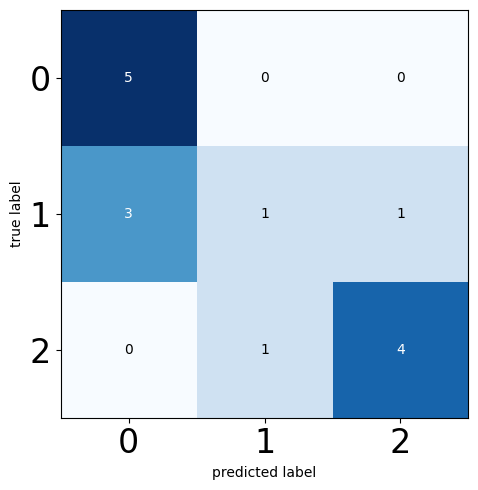

In [25]:
from sklearn.metrics import confusion_matrix, f1_score, roc_curve, precision_score, recall_score, accuracy_score, roc_auc_score
from sklearn import metrics
from mlxtend.plotting import plot_confusion_matrix
from keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


names = ['COBRE','ORO','ZINC']


test_data_dir = '/content/drive/MyDrive/minerales/prueba'  

test_datagen = ImageDataGenerator()

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(width_shape, height_shape), 
    batch_size = batch_size,
    class_mode='categorical', 
    shuffle=False)

custom_Model= load_model("model_Mobilenet.h5")
#modelt = custom_model

predictions = custom_Model.predict_generator(generator=test_generator)

y_pred = np.argmax(predictions, axis=1)
y_real = test_generator.classes


matc=confusion_matrix(y_real, y_pred)

plot_confusion_matrix(matc, figsize=(5,5), show_normed=False)
plt.tight_layout()

print(metrics.classification_report(y_real,y_pred, digits = 4))